## Using Yelp dataset to help users find the best restaurants via sentiment analysis and recommendation system
Whenever I need recommendations for restaurants, I Yelp. However, it is really difficult for me to distinguish two restaurants with similar average star ratings. While there could be thousands of reviews for a given restaurant, it is impossible to go through all them to extract the insights. More importantly, I would love to get recommendations based on my preference. Therefore, I propose to investigate Yelp’s dataset, which includes ~7GB data of business details, user, customer reviews and photos. By using sentiment analysis and recommender algorithm, I hope to assist customers discover the best restaurants that they will like. Yelp’s dataset is avaliable from Yelp’s 2019 dataset challenge (https://www.yelp.com/dataset).

## Outline

1. **Import and explore Data** <br>
    1a. Read Yelp business data <br>
    1b. Read Yelp user review data <br>
    1c. Filter the Yelp business, only select Chinese Restaurant business <br>
    1d. Merge the chinese restaurant business dataframe with the customer review dataframe <br>

2. **Present customer review data using Word Clouds** <br>
    2a. Review text preprocessing, clean reviews <br>
    2b. A word cloud image for reviews of Chinese restaurants <br>

3. **A new feature (positive review ratio for restaurants) to help users choose restaurants using Sentiment Analysis** <br>
    3a. Clean reviews and perform sentiment analysis <br>
    3b. Calculate the positive review ratio for Chinese restaurants <br>
    3c. Explore the relationship between restaurant "stars" rating and positive review ratio <br>

4. **Restaurant recommender system** <br>
    4a. Build a recommendation engine With collaborative filtering <br>
    4b. Recommendation generation: obtain a list of restaurants for a given user based on his preference<br>



In [110]:
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import nltk
from textblob import TextBlob
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from PIL import Image
from os import path
import pylab as pl
import pandas as pd
from sklearn.metrics import mean_squared_error

%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [111]:
pd.set_option('display.max_columns', 999)

## Part 1: Import and explore Data

### Part 1a: Read Yelp business data

In [15]:
# business = [json.loads(line) for line in open('business.json', 'r')]

# businessDF = json_normalize(business)

# businessDF.to_csv('business.csv')

In [112]:
businessDF = pd.read_csv('business.csv')

In [113]:
businessDF.head(2)

,Unnamed: 0,address,attributes.AcceptsInsurance,attributes.AgesAllowed,attributes.Alcohol,attributes.Ambience,attributes.BYOB,attributes.BYOBCorkage,attributes.BestNights,attributes.BikeParking,attributes.BusinessAcceptsBitcoin,attributes.BusinessAcceptsCreditCards,attributes.BusinessParking,attributes.ByAppointmentOnly,attributes.Caters,attributes.CoatCheck,attributes.Corkage,attributes.DietaryRestrictions,attributes.DogsAllowed,attributes.DriveThru,attributes.GoodForDancing,attributes.GoodForKids,attributes.GoodForMeal,attributes.HairSpecializesIn,attributes.HappyHour,attributes.HasTV,attributes.Music,attributes.NoiseLevel,attributes.Open24Hours,attributes.OutdoorSeating,attributes.RestaurantsAttire,attributes.RestaurantsCounterService,attributes.RestaurantsDelivery,attributes.RestaurantsGoodForGroups,attributes.RestaurantsPriceRange2,attributes.RestaurantsReservations,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.Smoking,attributes.WheelchairAccessible,attributes.WiFi,business_id,categories,city,hours.Friday,hours.Monday,hours.Saturday,hours.Sunday,hours.Thursday,hours.Tuesday,hours.Wednesday,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,0,2818 E Camino Acequia Drive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,1,30 Eglinton Avenue W,NaN,NaN,u'full_bar',"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,False,NaN,NaN,"{'garage': False, 'street': False, 'validated'...",NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,True,"{'dessert': False, 'latenight': False, 'lunch'...",NaN,NaN,False,NaN,u'loud',NaN,False,u'casual',NaN,False,True,2,True,True,True,NaN,NaN,u'no',QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,9:0-1:0,9:0-0:0,9:0-1:0,9:0-0:0,9:0-0:0,9:0-0:0,9:0-0:0,1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON


In [114]:
# data exploration
businessDF.shape
# businessDF.columns
# businessDF.dtypes
# businessDF.isnull().sum()
# businessDF['categories'][:5]

(192609, 59)

Text(0,0.5,'Count')

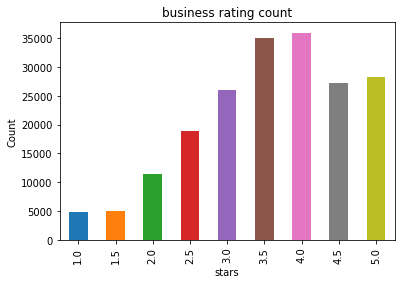

In [115]:
ratingCount = businessDF.groupby('stars').count()['city']
ratingCount.plot(kind = 'bar', title = 'business rating count')
plt.ylabel('Count')
plt.show()

### Part 1b: Read Yelp user review data

In [14]:
# review = [json.loads(line) for line in open('yelp_dataset/review.json', 'r')]

# reviewDF = json_normalize(review)

# reviewDF.to_csv('review.csv')

In [116]:
reviewDF = pd.read_csv('review.csv')

### Part 1c: Filter the Yelp business, only select Chinese Restaurant business

In [117]:
#By exploring the columns in the businessDF dataframe, I selected nice restaurant related columns and use them to filter out the restaurant business. these nine columns are: selected restaurant features; attributes.RestaurantsReservations; attributes.GoodForMeal; attributes.Caters; attributes.RestaurantsTableService; attributes.RestaurantsTakeOut; attributes.RestaurantsPriceRange2; attributes.RestaurantsAttire; attributes.RestaurantsGoodForGroups; attributes.RestaurantsDelivery

# Select restaurant/food business
restaurant = businessDF[(~businessDF['attributes.GoodForMeal'].isnull()) | (~businessDF['attributes.RestaurantsReservations'].isnull()) | \
                        (~businessDF['attributes.Caters'].isnull()) | (~businessDF['attributes.RestaurantsTableService'].isnull()) | \
                        (~businessDF['attributes.RestaurantsTakeOut'].isnull()) | (~businessDF['attributes.RestaurantsPriceRange2'].isnull()) | \
                        (~businessDF['attributes.RestaurantsAttire'].isnull()) | (~businessDF['attributes.RestaurantsGoodForGroups'].isnull()) | \
                        (~businessDF['attributes.RestaurantsDelivery'].isnull())]

# select Chinese restaurant/food business
ChineseRes = restaurant[restaurant['categories'].str.contains('Chinese') | restaurant['categories'].str.contains('chinese')\
                             | restaurant['categories'].str.contains('China')] 


In [118]:
print(ChineseRes.shape)

(4304, 59)


### Part 1d: Merge the chinese restaurant business dataframe with the customer review dataframe

In [31]:
# review_chinese = pd.merge(ChineseRes['business_id'], reviewDF, how = 'left', left_on = 'business_id', right_on = 'business_id')
# review_chinese.to_csv('review_chinese.csv')

In [119]:
review_chinese = pd.read_csv('review_chinese.csv')

In [120]:
print(review_chinese.shape)

(261214, 10)


In [121]:
review_chinese.head(2)

,Unnamed: 0,business_id,review_id,user_id,stars,useful,funny,cool,text,date
0,0,QXAEGFB4oINsVuTFxEYKFQ,6W0MQHmasK0IsaoDo4bmkw,2K62MJ4CJ19L8Tp5pRfjfQ,3.0,3,2,0,My girlfriend and I went for dinner at Emerald...,2017-01-27 21:54:30
1,1,QXAEGFB4oINsVuTFxEYKFQ,BeeBfUxvzD4qNX4HxrgA5g,A0kENtCCoVT3m7T35zb2Vg,3.0,0,0,0,We've always been there on a Sunday so we were...,2013-06-24 23:11:30


## Part 2: Present customer review data using Word Clouds

### Part 2a: Review text preprocessing, clean reviews

In [122]:
#removing numbers
def remove_num(text):
    text = ''.join([i for i in text if not i.isdigit()])
    return text

#removing punctuation
def remove_punct(text):
    text = ' '.join(word.strip(punctuation) for word in text.split() if word.strip(punctuation))
    return text

#removing other characters
def remove_u(text):
    text = text.replace('_','')
    text = text.replace('?','')
    text = text.replace('•','')
    text = text.replace("@",'')
    text = text.replace('▯','')
    text = text.replace("'",'')
    text = text.replace(",","")
    return text

#removing extra spaces
def remove_extra_space(text):
    word_list = text.split()
    text = ' '.join(word_list)
    return text

#removing very common words
#reference: https://gist.github.com/sebleier/554280
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the","Mr", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
def remove_stopwords(text):
    word_list = text.split()
    word_list = [word for word in word_list if word not in stop_words]
    text = ' '.join(word_list)
    return text

def clean_review(r):
    text1 = np.vectorize(remove_num)(r)
    text2 = np.vectorize(remove_punct)(text1)
    text3 = np.vectorize(remove_u)(text2)
    text4 = np.vectorize(remove_extra_space)(text3)
    text5 = np.vectorize(remove_stopwords)(text4)
    text = text5.tolist()
    return text

### Part 2b: A word cloud image for reviews of Chinese restaurants

In [123]:
# get a corpus of the review words
allText = ''.join(clean_review(review_chinese['text']))

In [124]:
mask = np.array(Image.open('cloudMask.jpg').convert('RGB'))

<Figure size 1440x1080 with 0 Axes>

(-0.5, 979.5, 783.5, -0.5)

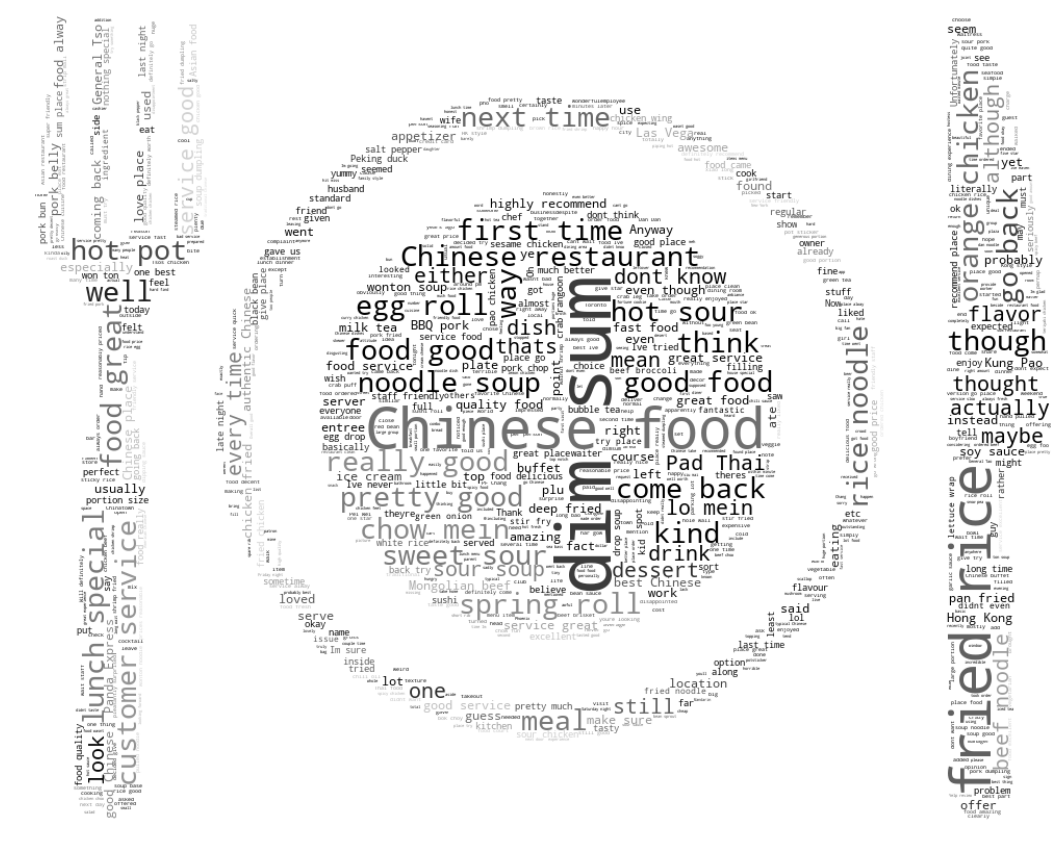

In [155]:
#creating wordcloud, top 1000 words
wordcloud = WordCloud(mask=mask, width=2000, height=1000,contour_color="black", max_words=1000,relative_scaling = 0, background_color = "white").generate(allText)
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,15])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
_=plt.show()

In [156]:
wordcloud.to_file('Plot 1: ChineseRestaurantWordCloud.png')

## Part 3: A new feature (positive review ratio for restaurants) to help users choose restaurants using Sentiment Analysis

### Part 3a: Clean reviews and perform sentiment analysis

In [127]:
# A function that perform sentiment analysis on each of the cleaned reviews
def sentiment(r):
    analysis = TextBlob(clean_review(r))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [128]:
review_chinese['sentiment'] = np.array([sentiment(review) for review in review_chinese['text']])

In [129]:
review_chinese[['text', 'useful', 'stars', 'sentiment']].head(2)

,text,useful,stars,sentiment
0,My girlfriend and I went for dinner at Emerald...,3,3.0,1
1,We've always been there on a Sunday so we were...,0,3.0,-1


### Part 3b: Calculate the positive review ratio for Chinese restaurants 
positive review ratio = positive reviews count / total review count for a given Chinese restaurant

In [130]:
businessSenti = review_chinese.groupby(['business_id', 'sentiment'])['review_id'].count().reset_index()
businessSenti.columns = ['business_id', 'sentiment', 'reviewCount']
businessReviewCount = review_chinese.groupby(['business_id'])['review_id'].count().reset_index()
businessReviewCount.columns = ['business_id', 'reviewTotalCount']
ReviewCountDF = pd.merge(businessSenti,businessReviewCount, how = 'left', left_on = 'business_id', right_on = 'business_id')

In [131]:
PositiveReviewCountDF = ReviewCountDF[ReviewCountDF['sentiment'] == 1]
PositiveReviewCountDF.loc[:,'PositiveReviewRatio'] = PositiveReviewCountDF.loc[:,'reviewCount']/PositiveReviewCountDF.loc[:,'reviewTotalCount']

In [132]:
PositiveReviewCountDF.head(2)

,business_id,sentiment,reviewCount,reviewTotalCount,PositiveReviewRatio
1,--6MefnULPED_I942VcFNA,1,40,46,0.869565
3,--SrzpvFLwP_YFwB_Cetow,1,39,44,0.886364


Text(0.5,0.98,'Histogram of Positive Review Ratio')

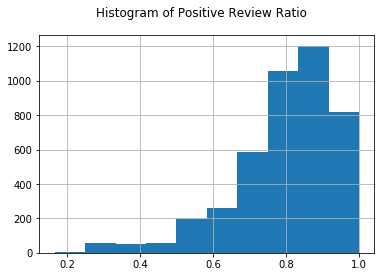

In [133]:
PositiveReviewCountDF['PositiveReviewRatio'].hist()
pl.suptitle('Histogram of Positive Review Ratio')

Text(0.5,0.98,'Histogram of reviewTotalCount')

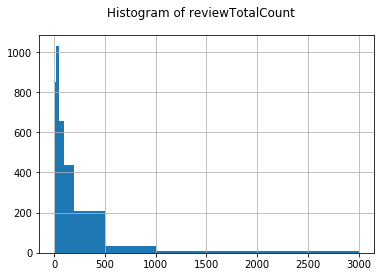

In [154]:
PositiveReviewCountDF['reviewTotalCount'].hist(bins = [5,10, 20, 50, 100, 200, 500, 1000, 3000])
pl.suptitle('Histogram of reviewTotalCount')

### Part 3c: Explore the relationship between restaurant "stars" rating and positive review ratio

In [272]:
ReviewWithStars = pd.merge(PositiveReviewCountDF[['business_id', 'reviewTotalCount', 'PositiveReviewRatio']], businessDF[['business_id', 'stars']], how = 'left', left_on = 'business_id', right_on = 'business_id')

# TO avoid the bias, I remove business that has less than ten reviews
ReviewWithStarsFilter = ReviewWithStars[ReviewWithStars['reviewTotalCount'] >= 40]

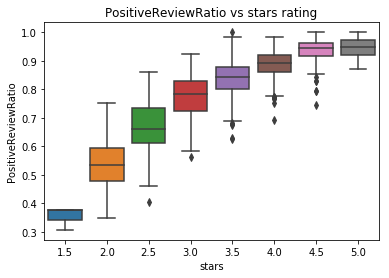

In [273]:
ax = sns.boxplot(x = 'stars', y = 'PositiveReviewRatio', data = ReviewWithStarsFilter).set_title('PositiveReviewRatio vs stars rating')

In [137]:
fig = ax.get_figure()
fig.savefig('Plot 2: Boxplot for positive review ratio of each stars category.png')

### Part 4: Restaurant recommender system

I will use Item Based Collaborative Filtering algorithm. Reasons as listed:
1. The number of users are way more than number of restaurants
2. Restaurants will not change frequently, lowering cost of calculation
3. Using user’s historical data, more convincing

I will use rating history from users to build relationship between restaurants. If one user rated two restaurants, these two are related.

In [138]:
review_chinese.head(2)
businessDF.head(2)

,Unnamed: 0,business_id,review_id,user_id,stars,useful,funny,cool,text,date,sentiment
0,0,QXAEGFB4oINsVuTFxEYKFQ,6W0MQHmasK0IsaoDo4bmkw,2K62MJ4CJ19L8Tp5pRfjfQ,3.0,3,2,0,My girlfriend and I went for dinner at Emerald...,2017-01-27 21:54:30,1
1,1,QXAEGFB4oINsVuTFxEYKFQ,BeeBfUxvzD4qNX4HxrgA5g,A0kENtCCoVT3m7T35zb2Vg,3.0,0,0,0,We've always been there on a Sunday so we were...,2013-06-24 23:11:30,-1


,Unnamed: 0,address,attributes.AcceptsInsurance,attributes.AgesAllowed,attributes.Alcohol,attributes.Ambience,attributes.BYOB,attributes.BYOBCorkage,attributes.BestNights,attributes.BikeParking,attributes.BusinessAcceptsBitcoin,attributes.BusinessAcceptsCreditCards,attributes.BusinessParking,attributes.ByAppointmentOnly,attributes.Caters,attributes.CoatCheck,attributes.Corkage,attributes.DietaryRestrictions,attributes.DogsAllowed,attributes.DriveThru,attributes.GoodForDancing,attributes.GoodForKids,attributes.GoodForMeal,attributes.HairSpecializesIn,attributes.HappyHour,attributes.HasTV,attributes.Music,attributes.NoiseLevel,attributes.Open24Hours,attributes.OutdoorSeating,attributes.RestaurantsAttire,attributes.RestaurantsCounterService,attributes.RestaurantsDelivery,attributes.RestaurantsGoodForGroups,attributes.RestaurantsPriceRange2,attributes.RestaurantsReservations,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.Smoking,attributes.WheelchairAccessible,attributes.WiFi,business_id,categories,city,hours.Friday,hours.Monday,hours.Saturday,hours.Sunday,hours.Thursday,hours.Tuesday,hours.Wednesday,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,0,2818 E Camino Acequia Drive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,1,30 Eglinton Avenue W,NaN,NaN,u'full_bar',"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,False,NaN,NaN,"{'garage': False, 'street': False, 'validated'...",NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,True,"{'dessert': False, 'latenight': False, 'lunch'...",NaN,NaN,False,NaN,u'loud',NaN,False,u'casual',NaN,False,True,2,True,True,True,NaN,NaN,u'no',QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,9:0-1:0,9:0-0:0,9:0-1:0,9:0-0:0,9:0-0:0,9:0-0:0,9:0-0:0,1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON


In [139]:
len(review_chinese['business_id'].unique())
len(review_chinese['user_id'].unique())
len(review_chinese['review_id'].unique())
len(review_chinese['sentiment'].unique())
review_chinese.shape

4304

153268

261214

3

(261214, 11)

In [255]:
#merge review with business information and postive review rati0
review_business = pd.merge(review_chinese[['business_id', 'user_id', 'stars', 'sentiment']], businessDF[['business_id', 'name', 'review_count', 'stars', 'city']], how = 'inner', left_on = 'business_id', right_on = 'business_id') #stars > 3
review_business_ratio = pd.merge(reviewIntermediate, PositiveReviewCountDF[['business_id', 'PositiveReviewRatio']], how = 'left', left_on = 'business_id', right_on = 'business_id')
reviewFinal = reviewFinal.rename(columns={"stars_x": "star", "stars_y": "ave_star"})
reviewFinal.shape

(261214, 9)

In [258]:
reviewFinal.head(2)

,business_id,user_id,star,sentiment,name,review_count,ave_star,city,PositiveReviewRatio
0,QXAEGFB4oINsVuTFxEYKFQ,2K62MJ4CJ19L8Tp5pRfjfQ,3.0,1,Emerald Chinese Restaurant,128,2.5,Mississauga,0.701493
1,QXAEGFB4oINsVuTFxEYKFQ,A0kENtCCoVT3m7T35zb2Vg,3.0,-1,Emerald Chinese Restaurant,128,2.5,Mississauga,0.701493


### Part 4a: Build a recommendation engine with collaborative filtering

In [259]:
def filter_res(reviewFinal, city, review_count):
    review_filter = reviewFinal[(reviewFinal['city'] == city) & (reviewFinal['review_count'] >= review_count)]
    return review_filter

In [260]:
def corr_matrix(reviewTable):
    corr_matrix = reviewTable.pivot_table(index='user_id', columns='business_id', values='star')
    return corr_matrix

In [264]:
def get_Restaurant(reviewFinal, user_id, city, review_count):
    review_res = filter_res(reviewFinal, city, review_count)
    restaurants = review_res[(review_res['user_id'] == user_id) & review_res['sentiment'] == 1]['business_id'].unique().tolist()
    if restaurants == []:
        print('No enough information to recommend restaurants')

    corr_lst = pd.DataFrame({'Correlation' : []})
    for res in restaurants:
        resMatrix = corr_matrix(review_res)
        res_rating = resMatrix[res]
        similarity = resMatrix.corrwith(res_rating)
        corr = pd.DataFrame(similarity, columns=['Correlation'])
        corr_lst = corr_lst.append(corr)
    
    recommender_raw1 = corr_lst.reset_index()
    recommender_raw1.columns = ['business_id', 'Correlation']
    recommender_raw2 = recommender_raw1[~recommender_raw1['business_id'].isin(restaurants)]
    recommender = recommender_raw2.sort_values(by='Correlation', ascending=False).head(15)
    final = pd.merge(recommender, reviewFinal[['business_id', 'name', 'ave_star', 'PositiveReviewRatio']], how = 'inner', left_on = 'business_id', right_on = 'business_id').drop_duplicates()
   
    return final[['business_id', 'name', 'Correlation', 'ave_star', 'PositiveReviewRatio']] 

### Part 4b: Recommendation generation: obtain a list of restaurants for a given user based on his preference

In [265]:
# recommended restaurant list for user '--6u02ZqjZRnwtX3t9bZtQ'
get_Restaurant(reviewFinal, '--6u02ZqjZRnwtX3t9bZtQ', 'Las Vegas', 10)

,business_id,name,Correlation,ave_star,PositiveReviewRatio
0,3TRgD3KLVis61eGvMZrykA,SK Seafood Restaurant 勝記,1.000000,4.0,0.928105
153,U1XLS-uQJVnQRvshnvAeXQ,The Little Kitchen Cafe,1.000000,3.5,0.777778
243,dVhGY-mNwTWQzK01Zxuclw,Yunnan Garden,1.000000,3.5,0.774920
554,EvE23d1PSbfGWe7EA5HRBQ,The Magic Noodle,1.000000,4.5,0.951501
987,JjjlhlQ2LEaQMuAug4fDIA,Yi Mei Champion Taiwan Deli,1.000000,3.5,0.873377
1295,VKmGedwOk-16D7OawNg_ng,Buffet At Asia,1.000000,3.0,0.767606
1721,x8O-Mll5ksDpeIgtA0XY-w,Buffet At Asia,1.000000,2.5,0.675573
1983,966W5oXOBW0ZWhNYy0yjcA,Wendy's Noodle Cafe,1.000000,4.0,0.913118
2570,EdY6q0CO2mlATpoTFkvHAw,Dim Sum Cafe,1.000000,4.0,0.916049
2975,IBNWrN1k9E0E_bMcRD-GwA,Chef Ching's Kitchen,1.000000,4.5,0.962025


In [266]:
get_Restaurant(reviewFinal, '--D8T8lqv2YnX8BebVQBdg', 'Las Vegas', 10)

,business_id,name,Correlation,ave_star,PositiveReviewRatio
0,5OqrwhtZ3mcmUSwLINZTWQ,Blossom,1.000000,4.0,0.941358
324,n0bg7kf6HcpFchCtxJyc5A,Mr Chow,1.000000,3.0,0.841191
727,hDL3Q-GNQlOuE04_zWEMJA,Krazy Buffet,1.000000,3.5,0.855000
1127,JdoBiBRgeS_KKaNaU1sofA,Dong Ting Spring,1.000000,4.0,0.884615
1205,-FcZY7a7qgxTUlTvwuyJnQ,8 Noodle Bar,1.000000,3.5,0.859259
1475,wOmtCPiB-xeU-HknjTW4hQ,China One,1.000000,3.5,0.859155
1546,czyhvf93Txsfxdxqcm16mA,Rice n Noodle,1.000000,4.0,0.885167
1964,UMWzaFhW6M3nsIDyIpMfhg,Little Dumpling,1.000000,3.5,0.928571
1978,TrN8HBHBL4-Tu7cXMDoopQ,Golden Flower Chinese Cuisine,1.000000,4.0,0.913793
2210,S5FTckOpSK0_Ma4c18ZEgg,Wo Fat,1.000000,3.5,0.707865
